In [1]:
import rioxarray
import rasterio
import numpy as np
import qinfer
import numpy.linalg as la
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import geopandas as gpd
from shapely.geometry.point import Point
import shapely.affinity
import subprocess
from osgeo import gdal
import pygeos
import json
import os
import pandas as pd
from tqdm import tqdm
import requests
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import esda
import libpysal
from scipy import stats

/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/qinfer/parallel.py:51: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  warnings.warn(


In [4]:
result['LISA_no_vehicle'].unique()

array(['Not_Sig', 'LH', 'HL', 'HH', 'LL', 'NA'], dtype=object)

In [2]:
result = gpd.read_file('./output/TAS_F_fim_geoid_corr.geojson')
result

,Dam_ID,Scenario,GEOID,Class,GEOID_tract,no_hs_dip,poverty,unprof_eng,mobile_home,no_vehicle,unemployed,age65,LISA_no_hs_dip,LISA_poverty,LISA_unprof_eng,LISA_mobile_home,LISA_no_vehicle,LISA_unemployed,LISA_age65,geometry
0,TX08005,TAS_F,480157601001000,0,48015760100,13.0,21.0,4.0,24.3,5.6,15.0,14.3,Not_Sig,Not_Sig,Not_Sig,LH,Not_Sig,LH,Not_Sig,"POLYGON ((-96.13950 29.71030, -96.13926 29.710..."
1,TX08005,TAS_F,480157601001000,0,48015760100,13.0,21.0,4.0,24.3,5.6,15.0,14.3,Not_Sig,Not_Sig,Not_Sig,LH,Not_Sig,LH,Not_Sig,"POLYGON ((-96.13950 29.71030, -96.13926 29.710..."
2,TX08005,TAS_F,480157601001000,0,48015760100,13.0,21.0,4.0,24.3,5.6,15.0,14.3,Not_Sig,Not_Sig,Not_Sig,LH,Not_Sig,LH,Not_Sig,"POLYGON ((-96.13950 29.71030, -96.13926 29.710..."
3,TX08005,TAS_F,480157601001000,0,48015760100,13.0,21.0,4.0,24.3,5.6,15.0,14.3,Not_Sig,Not_Sig,Not_Sig,LH,Not_Sig,LH,Not_Sig,"POLYGON ((-96.13950 29.71030, -96.13926 29.710..."
4,TX08005,TAS_F,480157601001000,0,48015760100,13.0,21.0,4.0,24.3,5.6,15.0,14.3,Not_Sig,Not_Sig,Not_Sig,LH,Not_Sig,LH,Not_Sig,"POLYGON ((-96.13950 29.71030, -96.13926 29.710..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6759870,TX05996,TAS_F,484879503002317,0,48487950300,26.0,26.0,1.0,17.9,2.5,1.7,25.4,Not_Sig,Not_Sig,Not_Sig,LH,Not_Sig,Not_Sig,Not_Sig,"POLYGON ((-99.47564 33.83435, -99.47546 33.834..."
6759871,TX05996,TAS_F,484879503002440,0,48487950300,26.0,26.0,1.0,17.9,2.5,1.7,25.4,Not_Sig,LH,Not_Sig,LH,Not_Sig,LL,Not_Sig,"POLYGON ((-99.29519 33.86033, -99.29505 33.860..."
6759872,TX05996,TAS_F,484879503002446,0,48487950300,26.0,26.0,1.0,17.9,2.5,1.7,25.4,Not_Sig,Not_Sig,Not_Sig,Not_Sig,Not_Sig,LL,Not_Sig,"POLYGON ((-99.27183 33.83424, -99.27184 33.834..."
6759873,TX05996,TAS_F,484879503002478,0,48487950300,26.0,26.0,1.0,17.9,2.5,1.7,25.4,LH,LH,Not_Sig,LH,Not_Sig,LL,Not_Sig,"POLYGON ((-99.33539 33.85346, -99.33376 33.856..."


In [8]:
result.columns

Index(['Dam_ID', 'Scenario', 'GEOID', 'Class', 'GEOID_tract', 'no_hs_dip',
       'poverty', 'unprof_eng', 'mobile_home', 'no_vehicle', 'unemployed',
       'age65', 'LISA_no_hs_dip', 'LISA_poverty', 'LISA_unprof_eng',
       'LISA_mobile_home', 'LISA_no_vehicle', 'LISA_unemployed', 'LISA_age65',
       'geometry'],
      dtype='object')

In [6]:
len(result['GEOID'].unique())

398667

In [5]:
abc = gpd.read_file('./output/TAS_F_fim_geoid.geojson')
abc

,Dam_ID,Scenario,GEOID,Class,geometry
0,TX08005,TAS_F,480157601001000,0,"POLYGON ((-96.13950 29.71030, -96.13926 29.710..."
1,TX08005,TAS_F,480157601001001,0,"POLYGON ((-96.14397 29.70947, -96.14348 29.709..."
2,TX08005,TAS_F,480157601001002,0,"POLYGON ((-96.17971 29.70472, -96.17858 29.705..."
3,TX08005,TAS_F,480157601001003,0,"POLYGON ((-96.18495 29.69997, -96.18265 29.702..."
4,TX08005,TAS_F,480157601001004,0,"POLYGON ((-96.18804 29.69719, -96.18766 29.697..."
...,...,...,...,...,...
1375364,TX00015,TAS_F,484579505002045,0,"POLYGON ((-94.37671 30.53174, -94.37658 30.532..."
1375365,TX00015,TAS_F,484579505002046,0,"POLYGON ((-94.38441 30.52758, -94.38434 30.527..."
1375366,TX00015,TAS_F,484579505002047,0,"POLYGON ((-94.40008 30.56685, -94.40002 30.566..."
1375367,TX00015,TAS_F,484579505002048,0,"POLYGON ((-94.40003 30.56146, -94.39982 30.561..."


In [7]:
len(abc['GEOID'].unique())

398667

In [3]:
# Import list of dams
fed_dams = requests.get('https://fim.sec.usace.army.mil/ci/fim/getAllEAPStructure').json()
fed_dams = pd.DataFrame(fed_dams)
fed_dams = gpd.GeoDataFrame(fed_dams, geometry=gpd.points_from_xy(fed_dams['LON'], fed_dams['LAT'], crs="EPSG:4326"))
fed_dams = fed_dams.loc[fed_dams['ID'].isin(result['Dam_ID'])]
print(fed_dams.shape[0])
fed_dams

KeyError: 'Dams_ID'

In [4]:
census_attr_dic = {'no_hs_dip': 'group(B06009)',     # Percentage of people over 25 without high school diploma
                    'poverty': 'group(B17001)',      # Percentage of people below the poverty level
                    'unprof_eng': 'group(B16005)',   # Percentage of resident with no proficient English
                    'mobile_home': 'DP04_0014PE',    # Percentage of mobile homes estimate
                    'no_vehicle': 'DP04_0058PE',     # Percentage of housholds without vehicle available estimate
                    'unemployed': 'DP03_0009PE',   # Unemployment Rate estimate
                    'age65': 'S0101_C02_030E'        # Percentage of person aged 65 and older estimate
                    }

census_attr_dic.keys()

dict_keys(['no_hs_dip', 'poverty', 'unprof_eng', 'mobile_home', 'no_vehicle', 'unemployed', 'age65'])

In [5]:
result = result.to_crs(epsg=4326)

/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


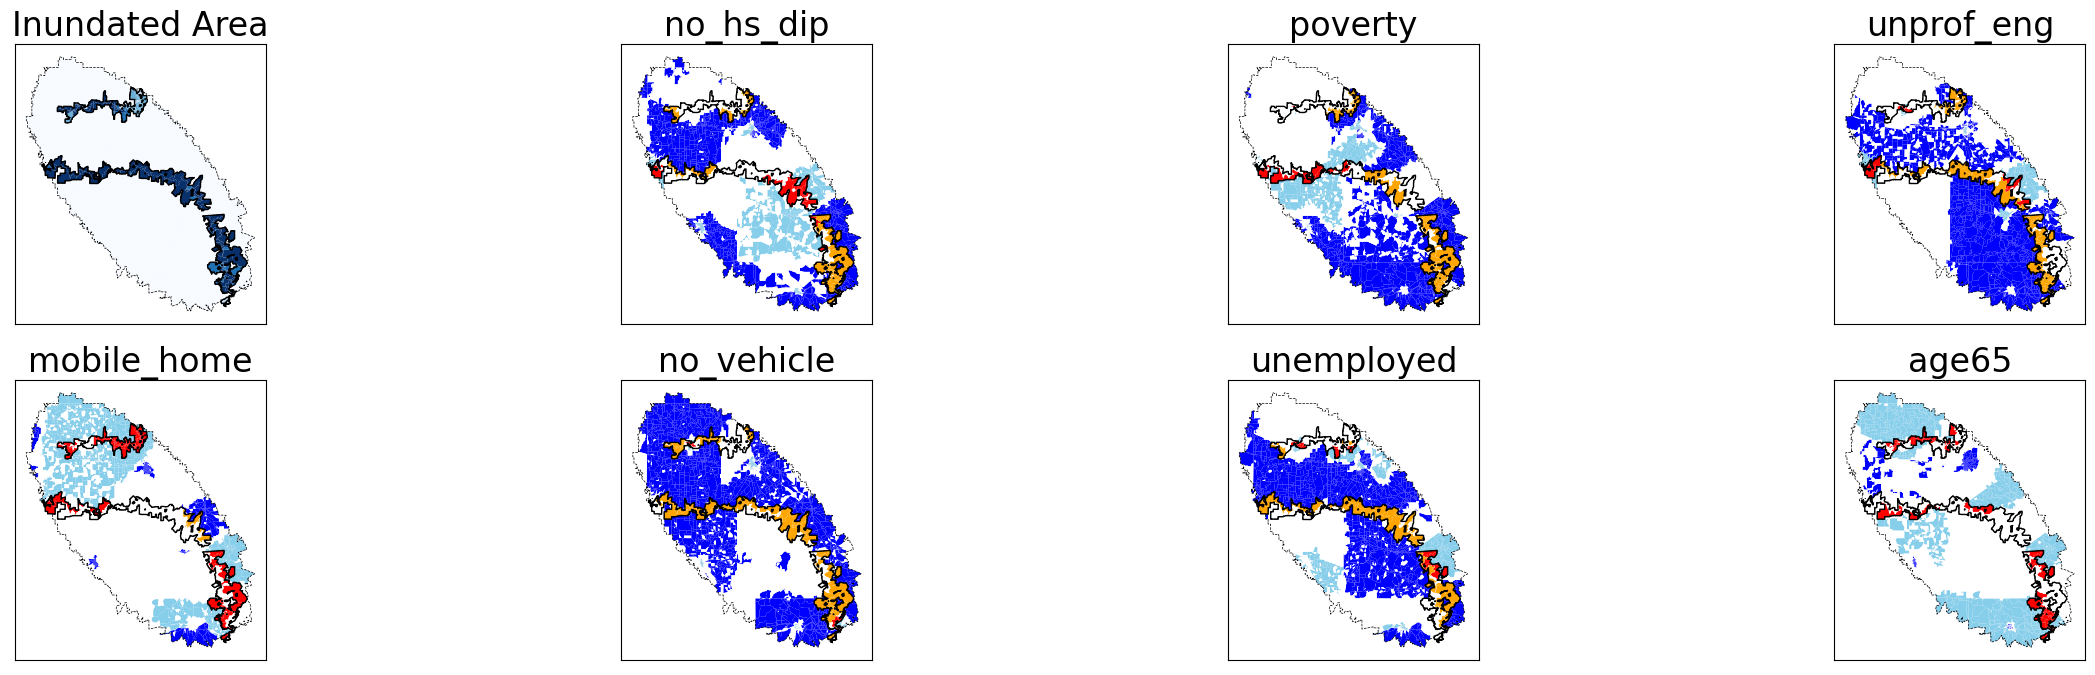

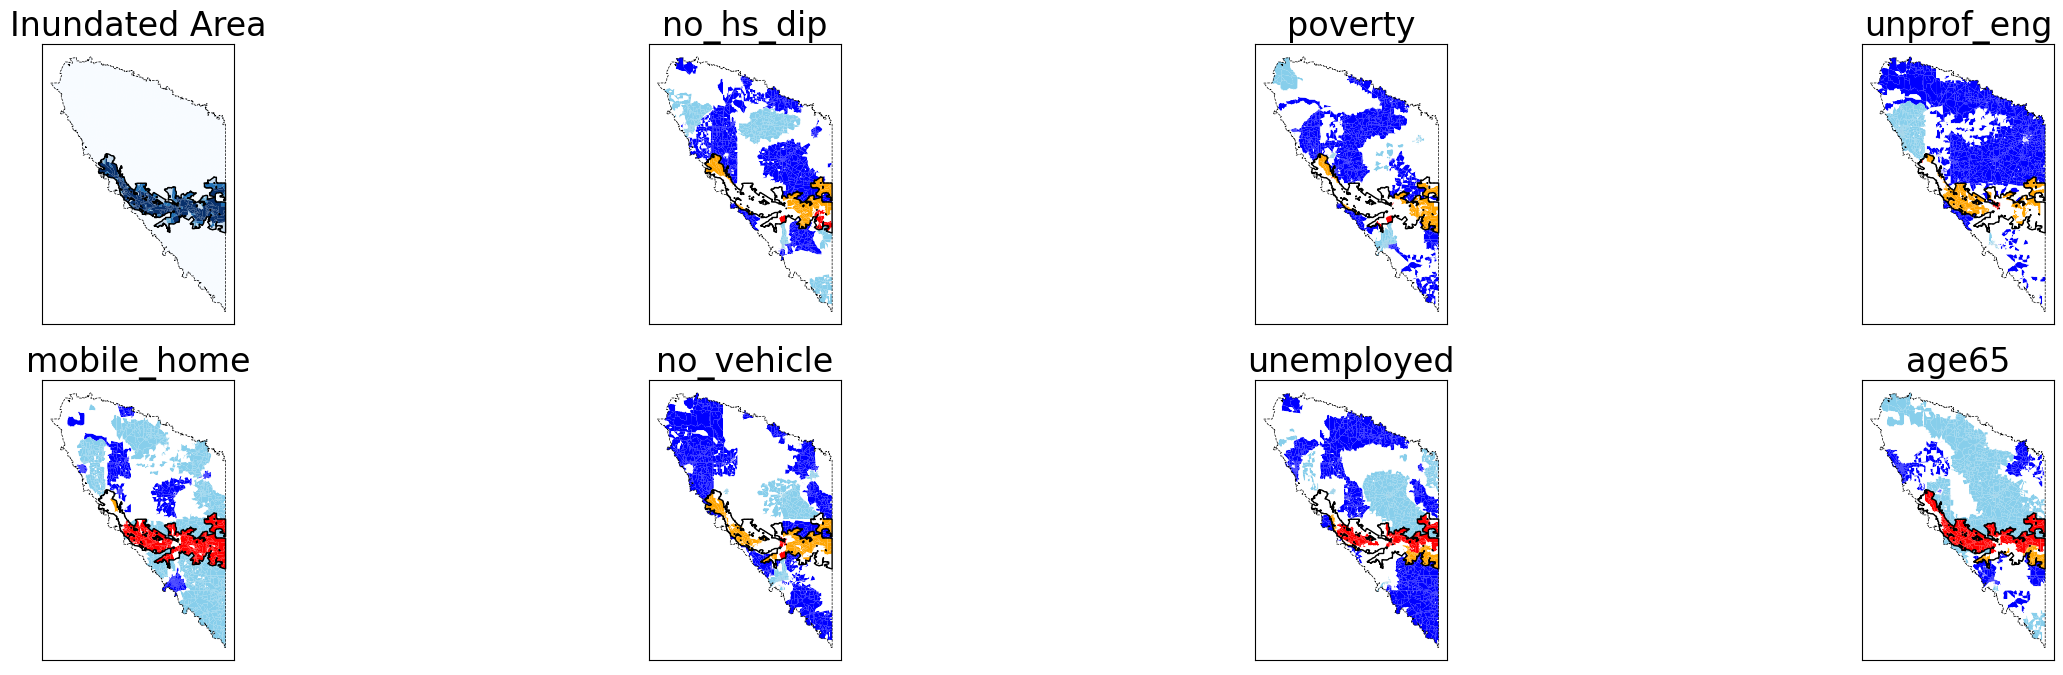

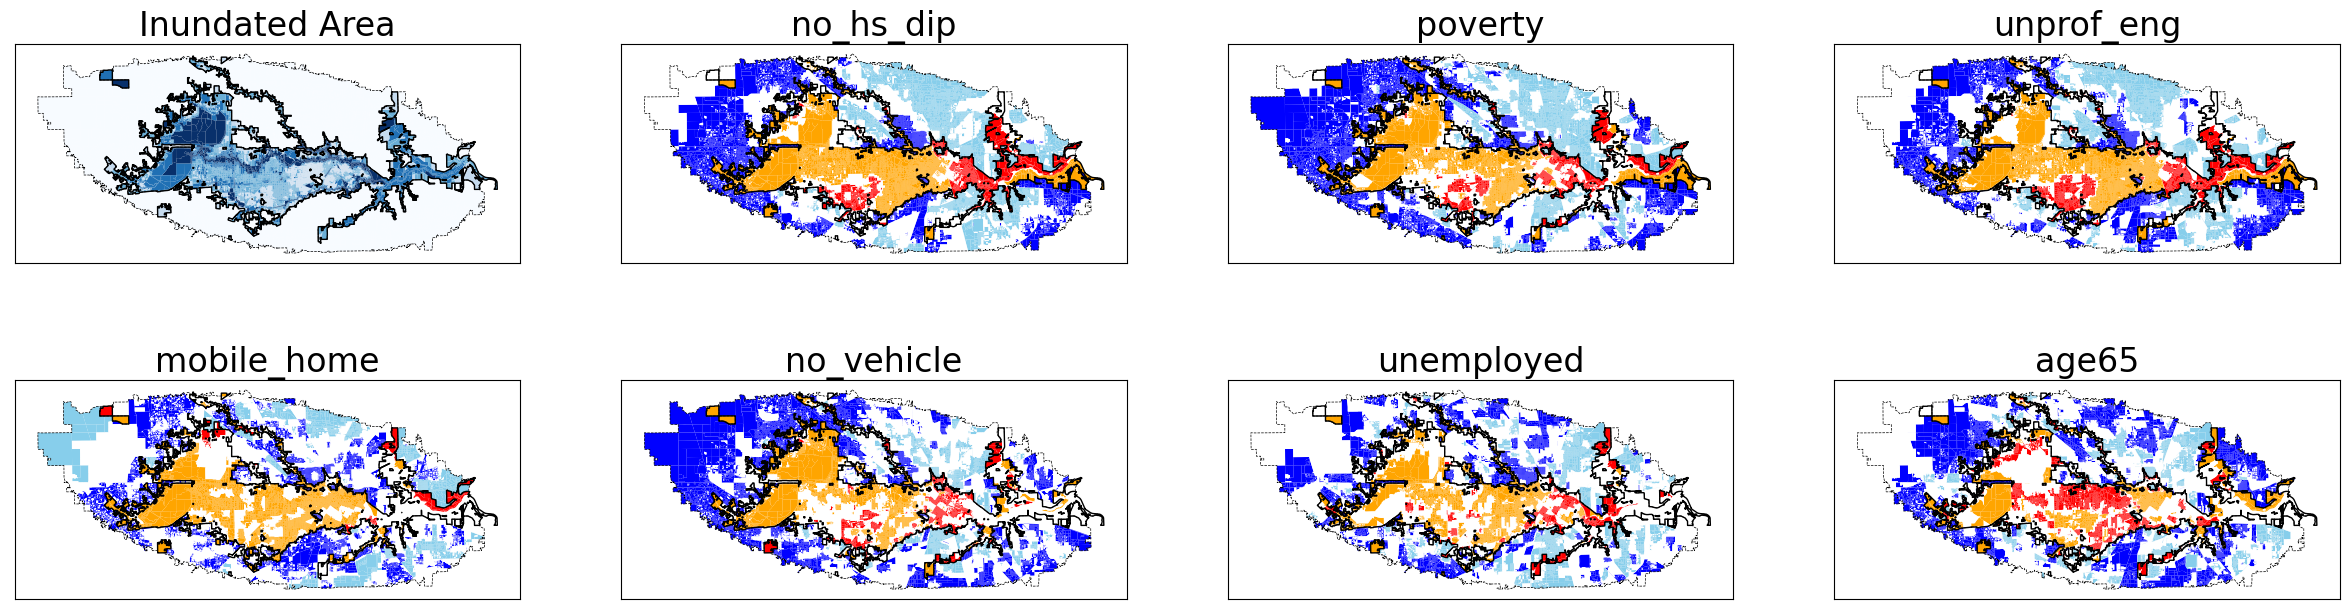

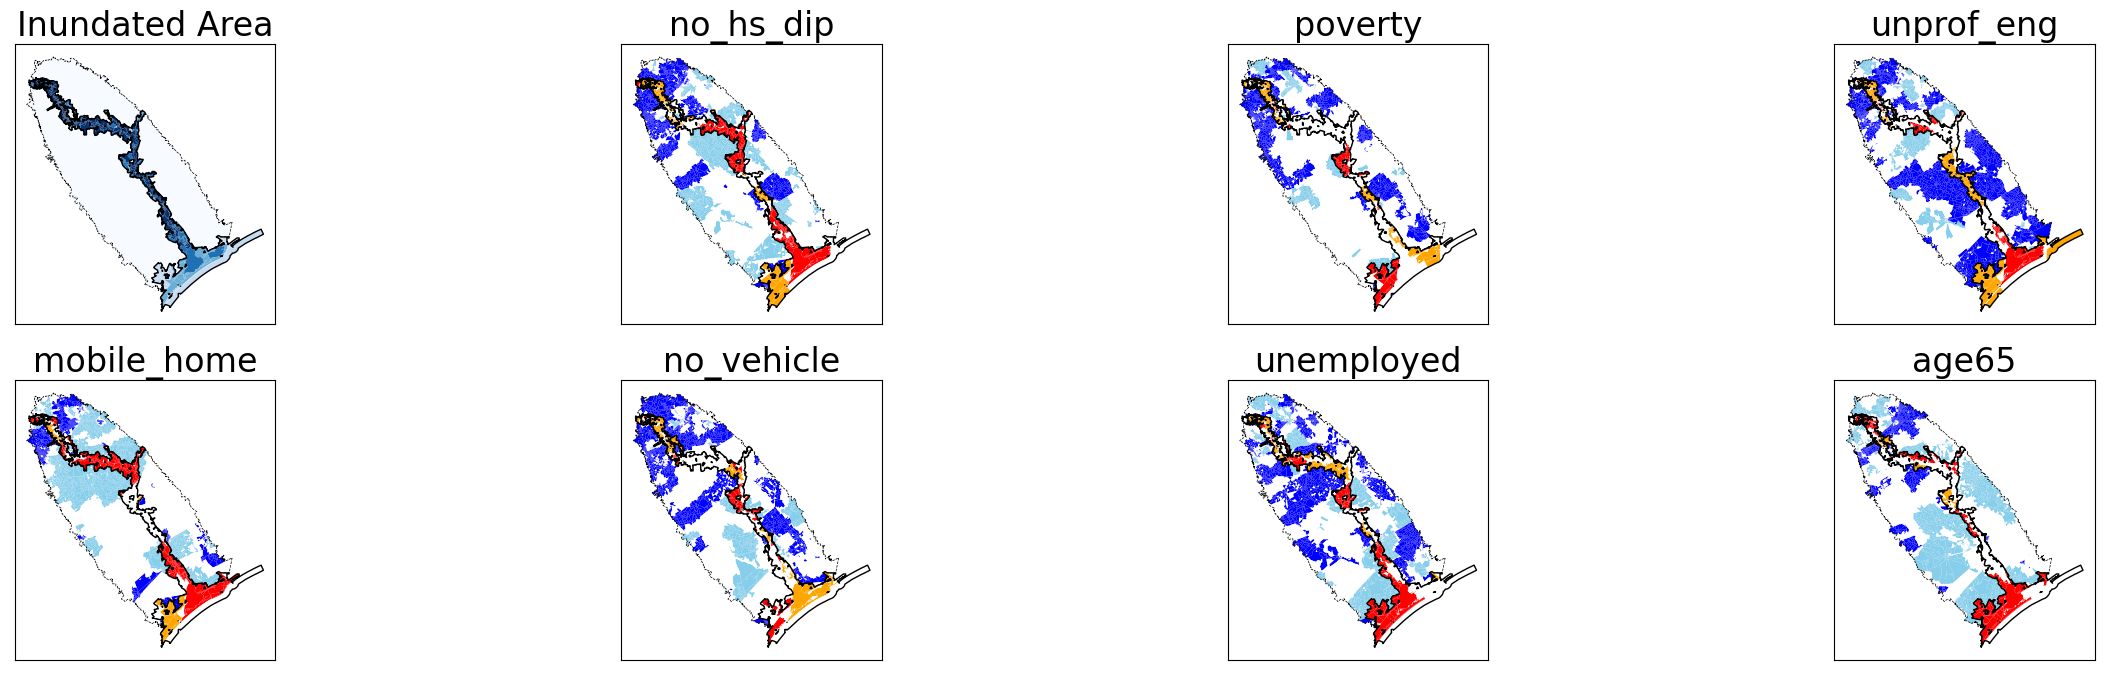

In [14]:
def plot_bivariate_moran_i_and_local_moran_i(dam_id, fim_geoid_gdf):
    fig, axes = plt.subplots(2, 4, figsize=(30, 8))
    ax = axes.reshape(-1)

    # Define geography related to each dam
    dam_area = fim_geoid_gdf.loc[fim_geoid_gdf['Dam_ID'] == dam_id].reset_index()

    benchmark_area = dam_area.loc[dam_area['Class'] == 0]
    inund_area = dam_area.loc[dam_area['Class'] > 0]
    benchmark_area_union = benchmark_area.dissolve(by='Dam_ID')
    inund_area_union = inund_area.dissolve(by='Dam_ID')

    fed_dams_focus = fed_dams.loc[fed_dams['ID'] == dam_id].reset_index()
    fed_dams_focus = fed_dams_focus.to_crs(epsg=5070)

    # Plot maps
    var_list = ['no_hs_dip', 'poverty', 'unprof_eng', 'mobile_home', 'no_vehicle', 'unemployed', 'age65']
    for m in range(8):
        if m == 0:
            fim_geoid_gdf[fim_geoid_gdf['Dam_ID'] == dam_id].plot('Class', cmap='Blues', ax=ax[m])
            ax[m].set_title(label="Inundated Area", fontsize=24)
        else:
            
            lisa_color = {'HH': 'red', 'LL': 'blue', 'HL': 'orange', 'LH': 'skyblue', 'Not_Sig': 'white'}
            
            for key in lisa_color.keys():
                fim_geoid_gdf.loc[(fim_geoid_gdf[f'LISA_{var_list[m-1]}'] == key) & (fim_geoid_gdf['Dam_ID'] == dam_id)].plot(ax=ax[m], color=lisa_color[key], legend=True)
            
            ax[m].set_title(label=f"{var_list[m-1]}", fontsize=24)

        benchmark_area_union.boundary.plot(ax=ax[m], color='black', lw=0.5, linestyle='dashed')
        inund_area_union.boundary.plot(ax=ax[m], color='black', lw=1)
        ax[m].get_xaxis().set_visible(False)
        ax[m].get_yaxis().set_visible(False)
        
    plt.show()
    
for dam_id in fed_dams['ID'].unique():

    plot_bivariate_moran_i_and_local_moran_i(dam_id, result)

In [13]:
fed_dams['ID'].unique()

array(['TX00006', 'TX00020', 'TX00018', 'TX00004'], dtype=object)